# Lecture 4 - Markov Chain Monte Carlo, `Stan`, and Complex Bayesian Models

## Today's Learning Objectives

1. Illustrate the steps to build a likelihood in a Bayesian design. 
2. Explore a complex dataset involving categorical, count, and continuous variables.
3. Apply a Bayesian model design with the proper random variables (**Normal**, **Gamma**, and **Poisson**).
4. Explain the general procedure of Markov Chain Monte Carlo (MCMC).
5. Practice computational Bayesian inference via `Stan`.
6. Draw inferential conclusions from our posterior distribution of parameters.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 10)
library(tidyverse)
library(janitor)
library(cowplot)
library(rstan)
library(bayesplot)
library(wesanderson)

── Attaching core tidyverse packages ─────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores

## Previously...

We have explored the Bayesian framework on a conceptual level at the beginning of the course. Then, we got familiar with the Bayes' rule via probability theory. Recall the Bayes' rule as one of **the most powerful components in Bayesian analysis**. By applying this rule, we solved a foundational model called the **Beta-Binomial** in which we combine two random variables via our likelihood and prior distribution. Moreover, we explored the **Gamma-Poisson** model during lab time.

Nonetheless, **real-life problems are not theoretically well behaved as the Beta-Binomial and Gamma Poisson cases**. Moreover, complex data will require even more diverse distributions to design our Bayesian model. Hence, the analytical application of the Bayes' rule will not be possible for a nice exact posterior distribution.

```{important}
Let us not worry! `Stan` will come in handy given this issue via MCMC to obtain an **approximate posterior distribution**.
```

## 1. The Big Idea

Let us recall the big idea of Bayesian modelling. It involves these steps:

1. **Question:** Pose a scientific question.
2. **Design:** Formulate variables and create a probabilistic model for them. Prior knowledge is included here!
3. **Infer:** Get **posterior samples** from the conditional distribution of **any variable you want to infer**, given your observed data and prior knowledge.
4. **Check:** Make sure the "samples" are *actually* from your posterior (these are model diagnostics, to be covered later!) 
5. **Analyze:** Use your samples to compute summaries: mean, maximum a posteriori (MAP), variance, posterior credible intervals, etc.

The **scientific question** can involve **inferential** and/or predictive inquiries:

- **Inferential:** Using observed data $Y$ to infer latent variable $\theta$. 
- **Predictive:** Using observed data $Y$ to predict future data $Y'$.

```{figure} ../img/graphical.png
:height: 350px
:name: graphical
```

We already discussed their differences in {doc}`lecture3_beta_binomial_Bayesian_modelling` our via some examples. Now, let us think generatively!

### 1.1. To Design the Model, Think Generatively!

Ultimately, **our model is an abstraction of a complex system involving different parameters of interest**. Suppose we have $d$ parameters $\theta_1, \dots, \theta_d$. Mathematically, these $d$ parameters can be put in a vector as follows:

$$\Theta = (\theta_1, \dots, \theta_d)^T.$$

Note our Bayesian model is a **big joint probability distribution $P(Y, Y', \Theta)$** over:

- **Things we will see.** Our observations $Y$.
- **Things we have to infer:** Unobserved parameters $\Theta$ and predicted observations $Y'$. **This is why the posterior distribution of $\Theta$ is key!**

We already had a first **inferential** approach (analytically speaking!) via the Beta-Binomial model in {doc}`lecture3_beta_binomial_Bayesian_modelling`.

Now, it is much more intuitive to design a couple of steps that generate parameters and synthetic data:

1. First, generate $\Theta$ from the **prior** $P(\Theta)$.
2. Then, generate observations $Y$, $Y'$ given $\Theta$ from the **likelihood** $P(Y,Y'|\Theta)$.

```{attention}
We are basically applying the law of conditioning

$$P(Y,Y',\Theta) = P(Y,Y'|\Theta)P(\Theta).$$
```

We will start with the **likelihood.** This function involves formulating certain variables. It is the core part of the model design! Then, we can establish the **prior distributions for our parameters of interest** within $\Theta$ (the likelihood will be of a big help here).

```{important}
This whole thing is a *story of how our data were created*.
```

So far in `lab1`, we only used our generative Monte Carlo models to simulate synthetic data given some fixed parameters. Nonetheless, we did not incorporate any observed data. **In `lab2`, we will need to include observed data.**

### 1.2. Constructing the Likelihood

To construct the distribution of **the model parameters in $\Theta$ conditioned on the observed data $Y$ (i.e., the likelihood)**, we need to follow these steps:

- **Step 1**: Formulate all data variables - **type** (integer, real, categorical, etc.) and **support** (positive, nonnegative, binary, etc.).
- **Step 2**: Figure out which variables we will take as fixed covariates, which will be randomly generated, and how they are related.
- **Step 3**: Pick a distribution with the right support/type/dependencies. The **support** refers to a proper range of plausible values. Usually, the distribution will have some **UNKNOWN PARAMETERS** - those will need a prior!

## 2. The Bikeshare Data

Let us recheck the bikeshare data. This is a complex case in which we have variables of different types.

- **Description:** Hourly record of the number of bike trips in Washington, DC in 2011/2012.
- **Source:** [2011/12 Capital Bikeshare Data](https://www.kaggle.com/marklvl/bike-sharing-dataset).
- **Variables:**  date, hour, holiday/weekend/workday, weather, temperature, number of trips.

```{admonition} Main statistical inquiries
Suppose we are interested in the following inferential inquiries:

1. How are temperature and weather associated with the **mean** number of trips?
2. Specifically, does the **mean** number of trips vary by the **type** of weather along with temperature?
3. How can we quantify this variation?
```

Let us start with **in-class questions**.

```{exercise}
:label: lecture4-q1

Let us retake **DSCI 562** topics under a frequentist approach; what regression modelling can approach the above inquiries?

**A.** A generalized linear model (GLM) such as Multinomial regression.

**B.** A GLM such as Ordinal Logistic regression.

**C.** A GLM such as Poisson regression.

**D.** Ordinary Least-squares (OLS).
```

### 2.1. Data Wrangling

The data frame `bikeshare_data` contains sixteen different variables. For the sake of our example and inquiries, we will use a small subset of them.

In [2]:
bikeshare_data <- read_csv("../data/bikeshare_hourly.csv", show_col_types = FALSE)
bikeshare_data

instant dteday     season yr mnth ⋯ hum  windspeed casual registered cnt
1     1       2011-01-01 1      0  1    ⋯ 0.81 0         3      13         16 
2     2       2011-01-01 1      0  1    ⋯ 0.80 0         8      32         40 
3     3       2011-01-01 1      0  1    ⋯ 0.80 0         5      27         32 
⋮     ⋮       ⋮          ⋮      ⋮  ⋮    ⋱ ⋮    ⋮         ⋮      ⋮          ⋮  
17377 17377   2012-12-31 1      1  12   ⋯ 0.60 0.1642     7     83         90 
17378 17378   2012-12-31 1      1  12   ⋯ 0.56 0.1343    13     48         61 
17379 17379   2012-12-31 1      1  12   ⋯ 0.65 0.1343    12     37         49

We quickly wrangle our data, select, and rename the three variables of interest:

- `weather`: A **categorical variable** indicating the overall weather situation. It is coded as:
    - `1`: Clear, Few clouds, Partly cloudy.
    - `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist.
    - `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds.
- `temp`: Temperature in Celsius degrees. The values are multiplied times 41 since they were normalized in the original dataset with the maximum value (you can check the [`Readme.txt`](https://www.kaggle.com/marklvl/bike-sharing-dataset)). **It is a continuous variable.**
- `ride_count`: Count of total rental bikes, including casual and registered. **It is an integer-type variable.**

```{attention}
Originally, there was a category `4` (Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog) in `weather`. Nonetheless, only three rows contained this category. Hence, they were removed, yielding 17376 rows in total to be used.
```

In [3]:
bikeshare_data <- bikeshare_data |>
  select(weathersit, temp, cnt) |>
  mutate(temp = temp * 41) |>
  filter(weathersit < 4)
colnames(bikeshare_data) <- c("weather", "temp", "ride_count")
bikeshare_data

weather temp  ride_count
1     1       9.84  16        
2     1       9.02  40        
3     1       9.02  32        
⋮     ⋮       ⋮     ⋮         
17374 1       10.66 90        
17375 1       10.66 61        
17376 1       10.66 49

In [4]:
nrow(bikeshare_data)

[1] 17376

### 2.2. Exploratory Data Analysis

There is a reason why the exploratory data analysis (EDA) is extremely helpful in Bayesian modelling. We might wonder, **how do ride counts behave by weather category?**

Firstly, let us plot histograms of `ride_count` by category in weather. Note the $y$-axis is adjusted with `after_stat(density)` since category `3` is present in fewer rows in `bikeshare_data`

In [5]:
bikeshare_data |> 
  tabyl(weather) |>
  adorn_pct_formatting()

weather n     percent
1 1       11413 65.7%  
2 2        4544 26.2%  
3 3        1419 8.2%

In [6]:
options(repr.plot.height = 7, repr.plot.width = 12)

bikeshare_data_hist <- ggplot(bikeshare_data, aes(
  x = ride_count, y = after_stat(density)
)) +
  geom_histogram(bins = 20, color = "darkblue", fill = "lightblue") +
  labs(y = "Density", x = "Bike Ride Count", fill = "") +
  ggtitle("Histograms by Weather Category") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
    strip.text.x = element_text(size = 21)
  ) +
  facet_grid(. ~ as.factor(weather))

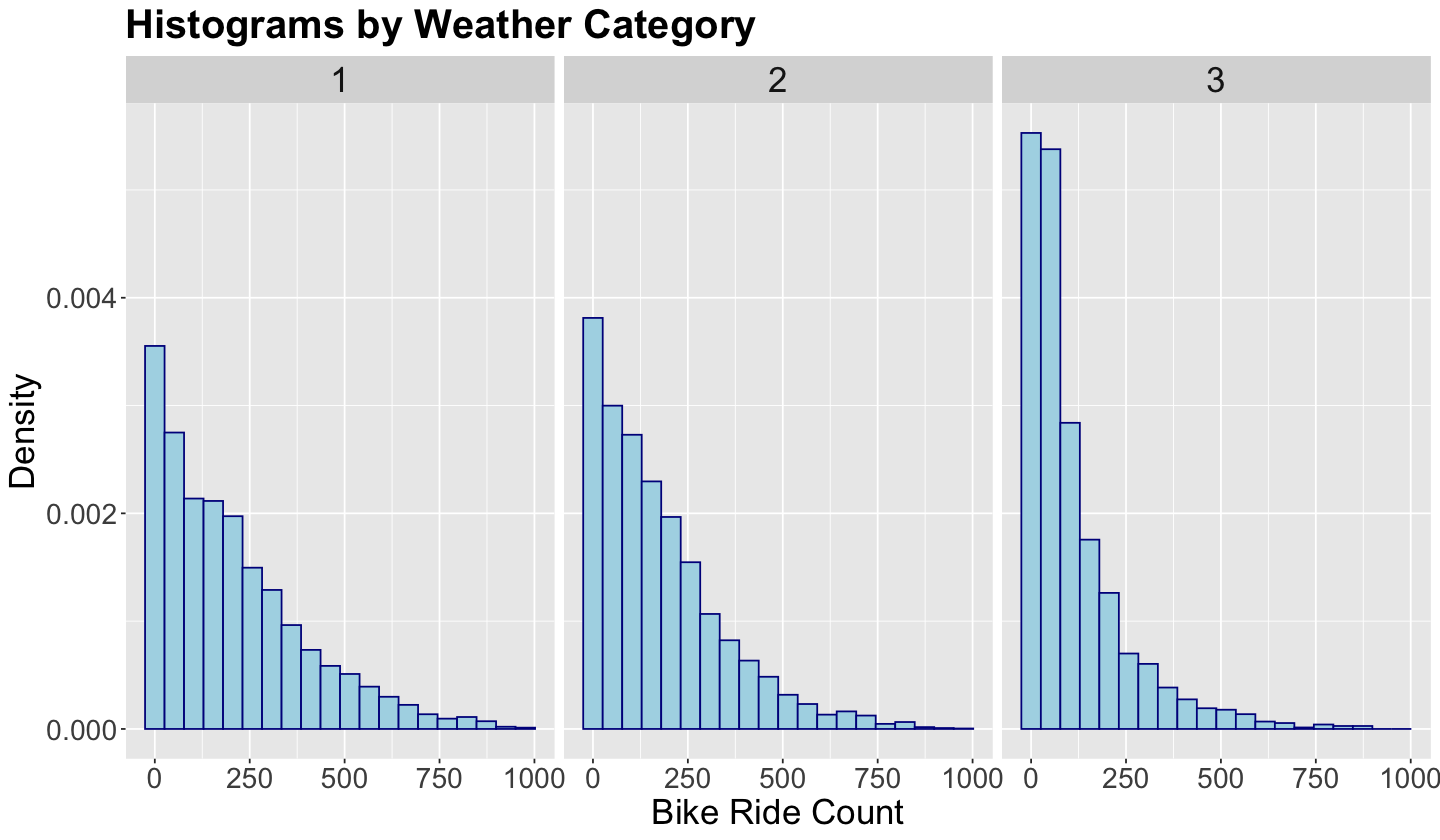

In [7]:
bikeshare_data_hist

Now, **how can we plot the relationship between `ride_count` and `temp` by `weather` category?** Let us create scatterplots of `temp` versus `ride_count` by weather `category`.

```{hint}
Identifying patterns with count versus continuous data is not straightforward. How about if we apply what we learned in **DSCI 562**? Let us fit a simple **frequentist** Poisson regression with a log-link function with `ride_count` as a response (the in-sample predictions are plotted as red lines).
```

In [8]:
bikeshare_data_scatterplot <- ggplot(bikeshare_data, aes(
  x = temp, y = ride_count
)) +
  geom_point(color = "blue") +
  labs(y = "Bike Ride Count", x = "Temperature (C)") +
  geom_smooth(
    data = bikeshare_data, aes(temp, ride_count), method = "glm", colour = "red",
    formula = "y ~ x",
    se = FALSE, method.args = list(family = poisson)
  ) +
  ggtitle("Scatterplots by Weather Category with Poisson Regression Fitted Lines") +
  theme(
    plot.title = element_text(size = 23, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
    strip.text.x = element_text(size = 21)
  ) +
  facet_grid(. ~ as.factor(weather))

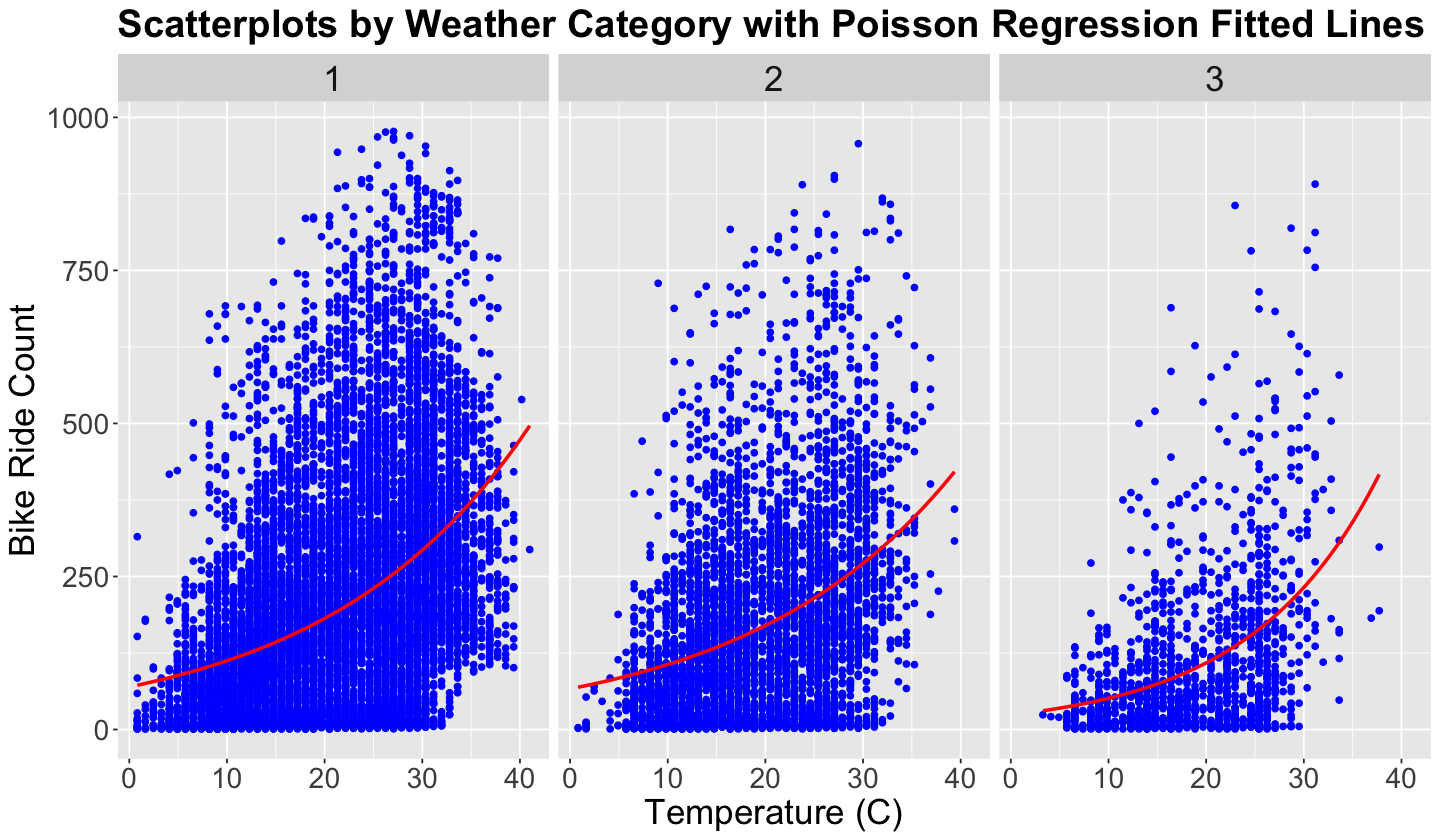

In [9]:
bikeshare_data_scatterplot

Based on our previous side-by-side plots (histograms and scatterplots), let us answer the following:

```{exercise}
:label: lecture4-q2

Graphically speaking, how do bike ride counts behave as we increase the weather category? Recall that a higher category represents harsher weather conditions.

**A.** When **harsher weather** conditions are present, the counts of bike rides **increase at a faster pace** when **temperature increases**.

**B.** When **nicer weather** conditions are present, the counts of bike rides **decrease at a faster pace** when **temperature increases**.

**C.** There is not graphical difference on the behaviour of bike rides as temperature increases across weather categories.

**D.** When **nicer weather** conditions are present, the counts of bike rides **increase at a faster pace** when **temperature increases**.
```

## 3. Bikeshare Likelihood

We have already obtained valuable insights with our EDA to proceed with our likelihood construction. Next, we will apply this likelihood to `bikeshare_data`. **It will contain appropriate random variables according to the type of variables present in the dataset.**

Note we have the following:

- **Weather situation** $w_i \in \{1, 2, 3\}$ (categorical, where `3` indicates the harshest conditions).
- **Temperature** $t_i \in \mathbb{R}$ (numerical).
- **Number of bike rides** $r_i$ (non-negative count).

### 3.1. Modelling the Bike Ride Counts

We do not need to **generate** temperature $t_i$ and weather situation $w_i$ for observation $i$ from our model. **We are not making a weather forecast model. We are only making inference here!** These are **covariates** that will modify the likelihood of our observations $r_i$ (**count of bike rides**):

- In regression, you have **inputs** and **output**. 
- Inputs are covariates in this case. We expect more rides when it is warmer **OR** weather is nicer (recall our EDA!). Thus, $w_i$ and $t_i$ (inputs) should influence $r_i$ (output).

So our model's observations $Y$ will be the collection of trip counts in `bikeshare_data` $(r_1, r_2, \dots)$. These are the rows in column `ride_count`.

We start with the rides $r_i$, which are counts. Hence, a suitable random variable for our Bayesian model is [**Poisson distribution**](poisson-distribution) whose mean $\lambda$ is theoretically equal to its variance.

<table style="font-size: 30px">
    <tr>
        <th>
           <center>Poisson Distribution</center>
<img style="float: right;" width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/1920px-Poisson_pmf.svg.png"/>
        </th>
    </tr>
</table>

> **Source:** Poisson distribution. (2025, January 25). In Wikipedia. [https://en.wikipedia.org/wiki/Poisson_distribution](https://en.wikipedia.org/wiki/Poisson_distribution)

Therefore, the **LIKELIHOOD** for bike ride counts is modelled as:

$$R_i \sim \text{Poisson}\left(\lambda_{w_i}(t_i)\right).$$

```{attention}
In the context of this problem, Poisson's mean will be in function of temperature $t_i$ **along** with the type of weather $w_i$.
```

```{admonition} How to define $\lambda_{w_i}(t_i)$?
:class: hint
This is one of the most critical modelling tasks, and we will need to use some distribution theory here, along with a mathematical function. Statistically speaking, the Poisson mean **cannot be negative**, even though it could be continuous!

Furthermore, let us make a **strong assumption** in our modelling. We will assume riders will start taking biking trips at a specific temperature, and **the riding rate will linearly increase with warmer temperature values**.
```

Mathematically, $\lambda_{w_i}(t_i)$ can be represented as:

```{math}
:label: poisson-lambda
\begin{equation}
\lambda_w(t) =  \log\{1+\exp[a_w (t - l_{w})]\}.
\end{equation}
```

The log-transformation is applying the idea we explored in [Poisson regression](https://ubc-mds.github.io/DSCI_562_regr-2/notes/lecture1-glm-link-functions-and-count-regression.html#poisson-regression). This also creates some unknown parameters for each $w \in \{1, 2, 3\}$:

- $a_w$ is the **slope** of mean trips in weather $w$.
- $l_w$ is the **elbow location** where riders start taking trips in weather $w$.

It will be easier to visualize function {eq}`poisson-lambda` in plots with different values for $a_w$ and $l_w$.

Suppose that for a weather category $w$ we model the following values:

- $a_w = 15$ and $l_w = 10$.
- $a_w = 10$ and $l_w = 0$.
- $a_w = 5$ and $l_w = -5$.
- $a_w = 2$ and $l_w = -10$.

In [10]:
options(repr.plot.height = 12, repr.plot.width = 12)

# Function to plot the mean count of bike rides over temperature values from -20 to 40 Celsius degrees.
# Parameters a and l need to be provided.
plot_mean_function <- function(a, l, plot_title) {
  ggplot() +
    xlim(-20, 40) +
    geom_function(fun = function(x) log(1 + exp(a * (x - l))), colour = "darkgreen", linewidth = 2) +
    geom_vline(xintercept = l, colour = "darkorange", linetype = "dashed", linewidth = 2) +
    labs(y = "Mean Bike Ride Count", x = "Temperature (C)") +
    theme(
      plot.title = element_text(size = 24, face = "bold"),
      axis.text.x = element_text(size = 17, angle = 0),
      axis.text.y = element_text(size = 17, angle = 0),
      axis.title = element_text(size = 21),
    ) +
    ggtitle(plot_title) +
    ylim(0, 500)
}
                  
a_15_l_10 <- plot_mean_function(a = 15, l = 10, plot_title = "a = 15 and l = 10")                  
a_10_l_0 <- plot_mean_function(a = 10, l = 0, plot_title = "a = 10 and l = 0")
a_5_l_minus_5 <- plot_mean_function(a = 5, l = -5, plot_title = "a = 5 and l = -5")
a_2_l_minus_10 <- plot_mean_function(a = 2, l = -10, plot_title = "a = 2 and l = -10")                 

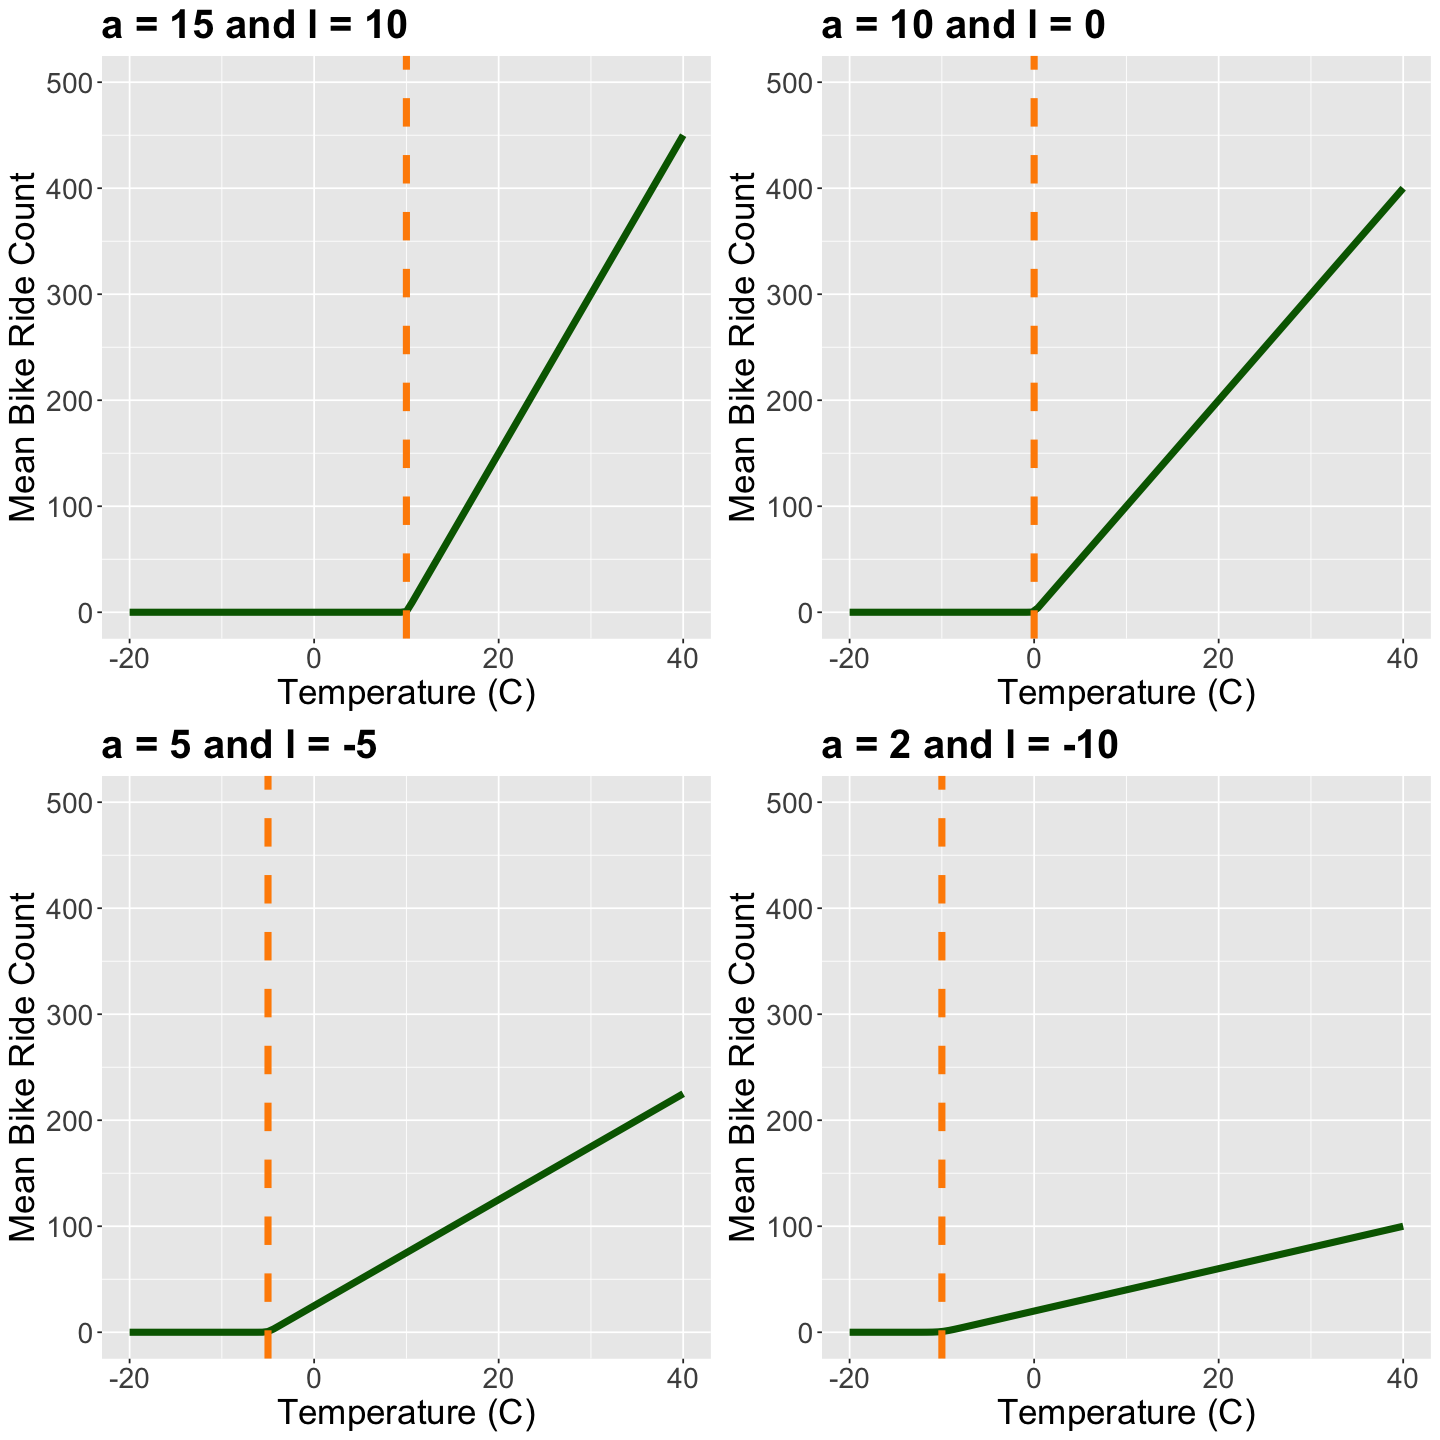

In [11]:
plot_grid(a_15_l_10, a_10_l_0, a_5_l_minus_5, a_2_l_minus_10)

```{exercise}
:label: lecture4-q3

**Descriptively**, what is the behaviour of our modelling function for $\lambda_w(t)$?
```

### 3.2. Modelling the Weather Parameters

We know weather status is **categorical**, temperature is **real**, and the number of rides is a **non-negative integer count**. Moreover, let us assume weather status and temperature are **fixed covariates** (we are not trying to model them). **The counts will be Poisson distributed.**

Nonetheless, our previous modelling of the behaviour of $\lambda_{w_i}(t_i)$ yielded six different **parameters** we need to model! Thus, let us find some suitable distributions for:

- $a_w$ with $w\in\{1,2,3\}$.
- $l_w$ with $w\in\{1,2,3\}$.

Our previous plots with different values of $a_w$ and $l_w$ shed light on what class of distributions will be suitable in our model:
- For the **CONTINUOUS** slopes $a_w$, we will assume they will only take on nonnegative values. A handy distribution for this case is the [**Gamma distribution**](gamma-distribution) 
- On the other hand, we will allow the **CONTINUOUS** elbows $l_w$ to take on any real value. Thus, the [**Normal distribution**](normal-distribution).

<table style="font-size: 30px">
    <tr>
       <th> 
           <center>Gamma Distribution</center>
    <img width="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/1920px-Gamma_distribution_pdf.svg.png"/>
        </th>
        <th>    
           <center>Normal Distribution </center>
<img width="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/1920px-Normal_Distribution_PDF.svg.png"/>
        </th>
    </tr>
</table>

> **Sources:**
> 
> Gamma distribution. (2025, January 14). In Wikipedia. [https://en.wikipedia.org/wiki/Gamma_distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
> 
> Normal distribution. (2025, January 26). In Wikipedia. [https://en.wikipedia.org/wiki/Normal_distribution](https://en.wikipedia.org/wiki/Normal_distribution)

Therefore, our **prior distributions** for these weather parameters would be:

```{math}
\begin{gather*}
l_w \sim \mathcal{N}(\mu, \sigma^2) \quad \text{for} \quad w\in\{1,2,3\} \\
a_w \sim \mathrm{Gamma}(k, \theta) \quad \text{for} \quad w\in\{1,2,3\}.
\end{gather*}
```

Now, we have **hyperparameters**! They are $\mu$, $\sigma^2$, $k$ and $\theta$.

Moreover, we will make them reflect uncertainty:

```{math}
\begin{gather*}
\mu = 0 \\
\sigma^2 = 15^2 = 225 \\
k = 1 \\
\theta = 1.
\end{gather*}
```

The corresponding prior distributions for $l_w$ and $a_w$ are plotted below (**the prior means are the vertical dashed red lines**). Note we are giving considerable uncertainty to $l_w$ while allowing any real number. On the other hand, we restrict $a_w$ to nonnegative numbers while allocating larger probabilities to small values (**i.e., we are not expecting large rates of change for the mean counts of bike rides**). 

In [12]:
options(repr.plot.height = 7, repr.plot.width = 12)

# Plotting Normal prior for l_w
prior_l_w <- ggplot() +
  xlim(-50, 50) +
  ylim(0, 0.03) +
  geom_function(fun = dnorm, args = list(mean = 0, sd = 15), linewidth = 2) +
  geom_vline(xintercept = 0, colour = "darkred", linetype = "dashed", linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(l["w"])) +
  ggtitle(expression("Prior Distribution for l"["w"]))

# Plotting Gamma prior for a_w
prior_a_w <- ggplot() +
  xlim(0, 5) +
  ylim(0, 1.2) +
  geom_function(fun = dgamma, args = list(shape = 1, rate = 1), linewidth = 2) +
  geom_vline(xintercept = 1, colour = "darkred", linetype = "dashed", linewidth = 2) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
  ) +
  labs(y = "Density", x = expression(a["w"])) +
  ggtitle(expression("Prior Distribution for a"["w"]))

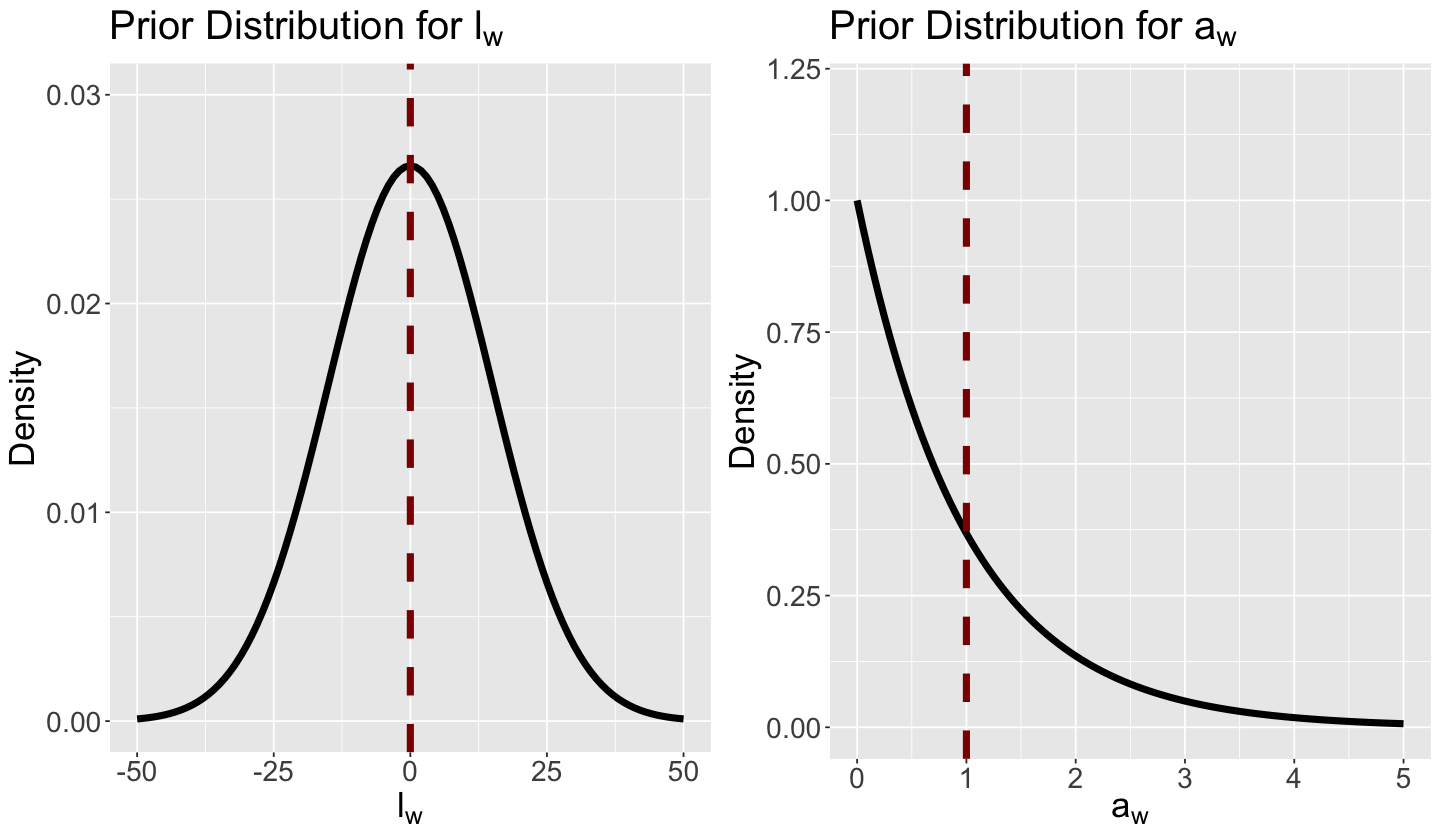

In [13]:
plot_grid(prior_l_w, prior_a_w)

Finally, with a dataset containing $n$ observations (i.e., rows in `bikeshare_data`), for the $i$th observation $(i = 1, \dots, n)$ with temperature $t_i$:

```{math}
\begin{align*}
\text{likelihood:} \qquad R_i \mid a_{w_i}, l_{w_i} \mathop\sim^\text{ind} \text{Poisson}\left(\lambda_{w_i}(t_i)\right) \\ \text{where} \quad \lambda_{w_i}(t_i) =  \log\{1+\exp[a_{w_i} (t_i - l_{w_i})]\} \quad \text{and} \quad w_i \in \{1, 2, 3\} \\
\text{priors:} \quad a_{w_i} \sim \mathrm{Gamma}(k = 1, \theta = 1) \\
\qquad l_{w_i} \sim \mathcal{N}(\mu = 0, \sigma^2 = 15^2).
\end{align*}
```

## 4. Overview of Markov Chain Monte Carlo

**In general**, a Bayesian model will have $d$ parameters of interest for which we will need to obtain a **joint posterior distribution**:

$$\Theta = (\theta_1, \dots, \theta_d)^T.$$

Recall the Bayes' rule:

$$\text{posterior} = \frac{\text{prior} \times \text{likelihood}}{\text{normalizing constant}} \propto \text{prior} \times \text{likelihood}.$$

Using $\Theta$ as our parameter **vector** of interest, let $f(\Theta)$ be the **multivariate** joint prior. Moreover with our observed data $\mathbf{y} = (y_1, \dots, y_n)^T$, let $\mathscr{l}(\Theta \mid \mathbf{y})$ be the corresponding **multivariate** likelihood function along with the **multivariate** normalizing constant $f(\mathbf{y})$. 

Then, for the **multivariate** joint posterior $f(\Theta \mid \mathbf{y})$, the Bayes' rule becomes:

$$f(\Theta \mid \mathbf{y}) = \frac{f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y})}{f(\mathbf{y})} \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

Why are we highlighting **multivariate** all the time? It is because we have $d$ parameters in vector $\Theta$. 

Suppose we want to obtain an **analytical** form for $f(\mathbf{y})$, then this will be an integral to solve:

$$f(\mathbf{y}) = \int_{\theta_1} \int_{\theta_2} \cdots \int_{\theta_d} f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y}) d\theta_d\ \cdots d\theta_1.$$

Solving this multivariate integral looks pretty challenging! Nonetheless, recall we do not need to obtain $f(\mathbf{y})$, but we still need to work around the math in

$$f(\Theta \mid \mathbf{y}) \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

```{important}
Cases such as the Beta-Binomial and Gamma-Poisson are **well behaved and approachable** for parameters $\pi$ and $\lambda$, respectively. Therefore, we can obtain a **closed solution** for the corresponding posterior distribution. 

But, **what can we do when we have a whole set of parameters in vector $\Theta$?** It will not be possible to find an exact form for $f(\Theta \mid \mathbf{y})$, but it is possible to approximate it via an algorithm!
```

Let us explore the MCMC algorithm by parts: **Markov Chain** and **Monte Carlo**.

### 4.1. Monte Carlo Algorithm

We will start with the simple Monte Carlo algorithm. Suppose you have a closed analytical form for the posterior distribution $f(\Theta \mid \mathbf{y})$ (e.g., the Beta posterior in the Beta-Binomial model). You can build your **independent** Monte Carlo sample $\{ \Theta_1, \dots, \Theta_N \}$ of size $N$, from $f(\Theta \mid \mathbf{y})$ by selecting each element $\Theta_i$ ($i = 1, \dots, N$) in the following way:

- **Step 1.** Draw $\Theta_i$ from $f(\Theta \mid \mathbf{y})$.
- **Step 2.** Go there.

This is a random walk!

```{caution}
Drawing **fully independent** elements for our sample **WILL NOT** be possible in MCMC. Moreover, **note that $n \neq N$**.
```

### 4.2. Markov Chain

Here comes the MCMC twist to the previous Monte Carlo approach: **Markov Chain**.

**What is a Markov Chain?** In terms of our Bayesian modelling for the posterior, it is a sequence $\{ \Theta_1, \dots, \Theta_N \}$ of size $N$ whose elements are **NOT ENTIRELY INDEPENDENT** (hence the word **chain**!).

**What does NOT ENTIRELY INDEPENDENT implicate?** It implicates the so-called **Markov property**: 

> *The next sampled $\Theta_{i + 1}$ will depend on the current $\Theta_{i}$ but not on previous $\Theta_{i - 1}, \Theta_{i - 2}, \dots$*

More formally, because of this property, the conditional probability function of $\Theta_{i + 1}$ can be depicted as:

$$f(\Theta_{i + 1} \mid \Theta_{i}, \mathbf{y}) = f(\Theta_{i + 1} \mid \Theta_1, \Theta_2, \dots \Theta_{i}, \mathbf{y}).$$

Again, **there is no free lunch here!** Each element in this chain can be drawn **from another distribution and not specifically from our target posterior $f(\Theta \mid \mathbf{y})$**:

$$f(\Theta_{i + 1} \mid \Theta_{i}, \mathbf{y}) \neq f(\Theta_{i + 1} \mid \mathbf{y}).$$

Thus, what is the point of this Markov Chain approach? The answer lies in the MCMC algorithm that approximates $f(\Theta \mid \mathbf{y})$ via our $N$ elements in the chain.

```{important}
There is more than one MCMC algorithm to do so, and the foundational one is the Metropolis-Hastings algorithm.
```

### 4.3. The Metropolis-Hastings Algorithm

This is the algorithm that will allow us to obtain **an approximation of the posterior distribution $f(\Theta \mid \mathbf{y})$** via our Markov Chain $\{ \Theta_1, \dots, \Theta_N \}$. Hence, with $\Theta_i$ in our current iteration $(i = 1, 2, \dots, N - 1)$, the next iteration $\Theta_{i + 1}$ will be selected through a two-step process.

Recall the Bayes' rule:

$$f(\Theta \mid \mathbf{y}) \propto f(\Theta) \times \mathscr{l}(\Theta \mid \mathbf{y}).$$

Let the current $\Theta_i = \Theta$. Then, the algorithm's two steps are: 

- **Step 1.** Randomly draw a new location $\Theta'$ from a proposed model with PDF $q(\Theta' \mid \Theta)$. This proposed model is what we call a jumping distribution and it could be a **Uniform** or **Normal** which are symmetric.

```{important}
Another choice of a jumping distribution could be **asymmetric**, such as the **Log-normal**. We can choose this jumping distribution class when there are constraints on our parameters of interest (e.g., they are nonnegative), or we want to sample large values from the chain (recall the Log-normal is a heavy-tailed distribution).
```

- **Step 2.** Now, let us decide to go or not to go to the proposed $\Theta'$:

```{important}
**Step 2** is divided in two parts:

a. Compute the acceptance probability for $\Theta'$:

$$\alpha = \min \bigg\{ 1, \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \times \frac{q(\Theta \mid \Theta')}{q(\Theta' \mid \Theta)} \bigg\}.$$

b. Obtain the next location $\Theta_{i + 1}$ as a Bernoulli trial (**flipping an unfair coin!**) taking on the two possible values:

$$
\Theta_{i + 1} =
\begin{cases}
\Theta' \; \; \; \; \mbox{with probability } \alpha\\
\Theta \; \; \; \; \mbox{with probability } 1 -\alpha.
\end{cases}
$$
```

### 4.4.  The Metropolis Algorithm

The previous Metropolis-Hastings algorithm can be simplified when the PDF of the jumping distribution is Uniform such that:

```{math}
\begin{equation*}
q(\Theta' \mid \Theta) = q(\Theta \mid \Theta') =
\begin{cases}
\frac{1}{2w} \; \; \; \; \mbox{when $\Theta$ and $\Theta'$ are within $w$ units of each other} \\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```

This jumping distribution allocates the same probability of switching from $\Theta$ to $\Theta'$ compared to switching from $\Theta'$ to $\Theta$. Note that $w$ is the window parameter. Having said that, the definition of $\alpha$ will change to:

$$\alpha = \min \bigg\{ 1, \frac{f(\Theta') \mathscr{l}(\Theta' \mid \mathbf{y})}{f(\Theta) \mathscr{l}(\Theta \mid \mathbf{y})} \bigg\}.$$

### 4.5.  Other MCMC Algorithms

Metropolis-Hastings and its simplified Metropolis version are only a couple of MCMC tools. These two approaches target single parameters (e.g., a probability of success $\pi$ or a mean $\lambda$). However, when we want to deal with $d$ parameters, such as $\Theta = (\theta_1, \dots, \theta_d)^T$, there are more complex tools like Gibbs sampling (used in [JAGS, Just Another Gibbs Sampler](https://mcmc-jags.sourceforge.io)) or the [**No-U-Turn sampler (NUTS)**](https://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) which is a Hamiltonian Monte Carlo (HMC) algorithm (implemented in [`Stan`](https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html)). 

### 4.6.  Important Facts to Consider when `sampling()` via `rstan`

The MCMC algorithm has a **learning curve**; thus, the Markov Chain initially starts sampling unreasonable numbers to approximate the posterior $f(\Theta \mid \mathbf{y})$. Therefore, we have a **burn-in stage** at the beginning of `sampling()` defined by the parameter `warmup`. This parameter will discard the first `warmup` iterations for the final simulation output.

Recall that consecutive elements in the chain **are not independent**. Hence, given the Markov property, we could skip draws between our definitive sampled values throughout the simulation to achieve **a certain degree of sampling independence**. This is defined by `thin`.

```{important}
We will obtain the following number of **approximate posterior samples** via `sampling()`:

$$\texttt{Number of approximate posterior samples} = \frac{\texttt{iter} - \texttt{warmup}}{\texttt{thin}}.$$
```

## 5. Using `Stan` to Obtain our Posterior Distribution

We already designed our Bayesian model. Now it is time to code it in `Stan`. Recall that with a dataset containing $n$ observations (i.e., rows in `bikeshare_data` which is our training set size), for the $i$th observation $(i = 1, \dots, n)$ with temperature $t_i$:

```{math}
\begin{align*}
\text{likelihood:} \qquad R_i \mid a_{w_i}, l_{w_i} \mathop\sim^\text{ind} \text{Poisson}\big(\lambda_{w_i}(t_i)\big) \\ \text{where} \quad \lambda_{w_i}(t_i) =  \log\{1+\exp[a_{w_i} (t_i - l_{w_i})]\} \quad \text{and} \quad w_i \in \{1, 2, 3\} \\
\text{priors:} \quad a_{w_i} \sim \mathrm{Gamma}(k = 1, \theta = 1) \\
\qquad l_{w_i} \sim \mathcal{N}(\mu = 0, \sigma^2 = 15^2).
\end{align*}
```

### 5.1. Coding the Model

Recall `Stan` has a **block structure**. Therefore, we will use the following blocks:

- `data`: The **inputs** needed to run the Bayesian model.
- `parameters`: The **parameters** to be sampled **for our posterior analysis** ($a_w$ and $l_w$ for $w \in \{1, 2, 3\}$). Their **approximate posterior distributions** will allow us to establish the extent to which temperature and mean bike ride count are related across different categories of weather (**this is Bayesian inference!**).
- `model`: Our Bayesian model.

```{caution}
`Stan` needs to know every single detail of our `data` and generative `model` (object types, sizes, loops, etc.).
```

Unlike the `R` markdown, we do not have a `Stan` cell in Jupyter notebook/lab. Hence, we need to code our `bikeshare_model` as a string.

In [14]:
bikeshare_model <- "data {                          
int<lower=1> number_weather_cat;      // integer to indicate how many weather categories we have
int<lower=1> n;      // how many rows we have in bikeshare_data                               
vector[n] temp;      // column bikeshare_data$temp of real type
int<lower=1> weather[n];      // column bikeshare_data$weather as integer                      
int<lower=0> ride_count[n];      // column bikeshare_data$ride_count as integer                    
}
parameters {
vector<lower=0>[number_weather_cat] a;      // a vector of size number_weather_cat for a_w
vector[number_weather_cat] l;      // a real-type vector of size number_weather_cat for l_w
}
model {
for (j in 1:number_weather_cat){      // we have three PAIRS of priors, i.e., one PAIR per weather category
  a[j] ~ gamma(1, 1);
  l[j] ~ normal(0, 15);
}
for (i in 1:n){      // building our likelihood
  int w_index = weather[i];      // auxiliary variable for the ith weather category
  ride_count[i] ~ poisson(log(1 + exp(a[w_index] * (temp[i] - l[w_index]))));
}
}"

### 5.2. MCMC Simulation

Next, we create a **dictionary** with all the `data` variables we need to pass into `Stan` as a `list()`.

In [15]:
bikeshare_dictionary <- list(
  number_weather_cat = 3,
  n = nrow(bikeshare_data), 
  temp = bikeshare_data$temp,
  weather = as.integer(bikeshare_data$weather),
  ride_count = as.integer(bikeshare_data$ride_count)
)

**We have not compiled `bikeshare_model`.** Hence, we cannot use `sampling()` directly but `stan()` as in the cell below. Note the MCMC arguments are provided as in `sampling()`:

- `chains`: **How many times** we want to run the Bayesian simulation.
- `iter`: The **number of approximate posterior sampled sets of `parameters`** we want (including **burn-in**).
- `warmup`: The **burn-in** period.
- `thin`: Number of samples to **skip** between each draw.
- `seed`: Reproducibility seed.

In [16]:
posterior_bikeshare <- stan(
  model_code = bikeshare_model,
  data = bikeshare_dictionary,
  chains = 1,
  iter = 20000,
  warmup = 2000,
  thin = 40,
  seed = 553,
  verbose = TRUE,
  algorithm = "NUTS"
)


TRANSLATING MODEL '' FROM Stan CODE TO C++ CODE NOW.
OS: aarch64, darwin20; rstan: 2.32.6; Rcpp: 1.0.12; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/rstan/lib//libStanServices.a' -L'/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/StanHeaders/lib/' -lStanHeaders -L'/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/RcppParallel/lib/' -ltbb -L/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/RcppParallel/lib -ltbb -ltbbmalloc
PKG_CPPFLAGS =   -I"/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/Rcpp/include/"  -I"/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/RcppEigen/include/"  -I"/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/RcppEigen/include/unsupported"  -I"/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/BH/include" -I"/Library/Frameworks/R.framework/Ve

### 5.3. Obtaining, Visualizing, and Interpreting the Posterior Results

> **`posterior_bikeshare` is our one-stop-shop!**

We obtained a total of 

$$\frac{\texttt{iter} - \texttt{warmup}}{\texttt{thin}} = \frac{20000 - 2000}{40} = 450$$

approximate posterior samples **to be summarized in our inferential conclusions**.

You can obtain the `summary()` statistics for the object `posterior_bikeshare`. These statistics are drawn from the **approximate joint posterior distribution** of the `parameters` of interest: $a_1$, $a_2$, $a_3$, $l_1$, $l_2$, and $l_3$. Lower and upper bounds for the **95% credible intervals** are shown in columns `2.5%` and `97.5%`.

Metrics `se_mean` (Monte Carlo standard error), `n_eff` (effective sample size), and `Rhat` are model diagnostics (**to be covered later on at the end of this course**).

```{attention}
`lp__` refers to the logarithm of the posterior joint density **up to a constant that does not depend on the parameters of interest** (we will not use it in this course).

You can find a useful [**optional resource**](https://www.jax.org/news-and-insights/jax-blog/2015/october/lp-in-stan-output) if you are more interested in knowing how `Stan` performs its computation.
```

In [17]:
round(summary(posterior_bikeshare)$summary, 2)[-7, ]

mean  se_mean sd   2.5%  25%   50%   75%   97.5% n_eff  Rhat
a[1]  9.46 0       0.01  9.44  9.46  9.47  9.47  9.49 423.09 1   
a[2]  8.20 0       0.03  8.16  8.19  8.20  8.22  8.25 427.82 1   
a[3]  7.00 0       0.03  6.93  6.98  7.00  7.02  7.06 418.97 1   
l[1] -0.69 0       0.03 -0.75 -0.71 -0.69 -0.68 -0.64 454.05 1   
l[2] -1.90 0       0.06 -2.02 -1.95 -1.91 -1.86 -1.78 480.15 1   
l[3]  2.78 0       0.06  2.67  2.75  2.78  2.83  2.90 398.77 1

Before plotting our posterior results, let us recheck the inferential inquiries:

> 1. *How are temperature and weather associated with the **mean** number of trips?*
> 2. *Specifically, does the **mean** number of trips vary by the **type** of weather along with temperature?*
> 3. *How can we quantify this variation?*

Now, we can also plot the six 95% credible intervals and posterior distributions via `mcmc_areas()` (from package `bayesplot`). Based on our summary and credible intervals, we can conclude the following (**while addressing the previous inquiries**):

- Indeed, **we have posterior evidence** to state that the rates of change for mean counts of bike rides ($a_w$) are different by weather category (the corresponding 95% credible intervals do not overlap!). **A higher rate of change mean count is associated to a nicer weather.**
- The temperature elbows $l_w$ by weather category are also different (the corresponding 95% credible intervals do not overlap!).

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


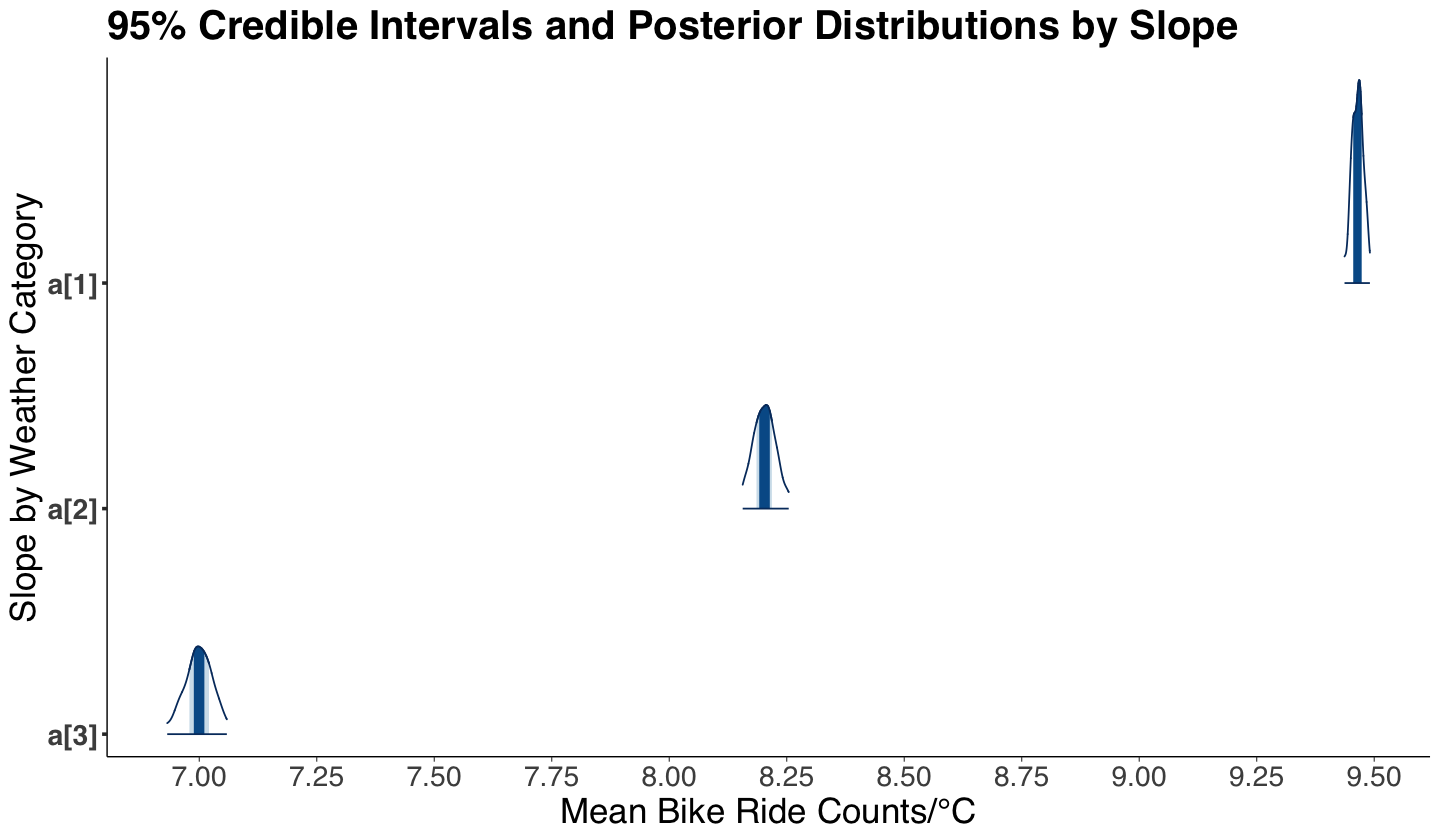

In [18]:
slope_CIs <- mcmc_areas(posterior_bikeshare, pars = c("a[1]", "a[2]", "a[3]"), prob_outer = 0.95) +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  ggtitle("95% Credible Intervals and Posterior Distributions by Slope") +
  scale_x_continuous(breaks = seq(7, 10, 0.25)) +
  labs(x = "Mean Bike Ride Counts/°C", y = "Slope by Weather Category")

slope_CIs

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


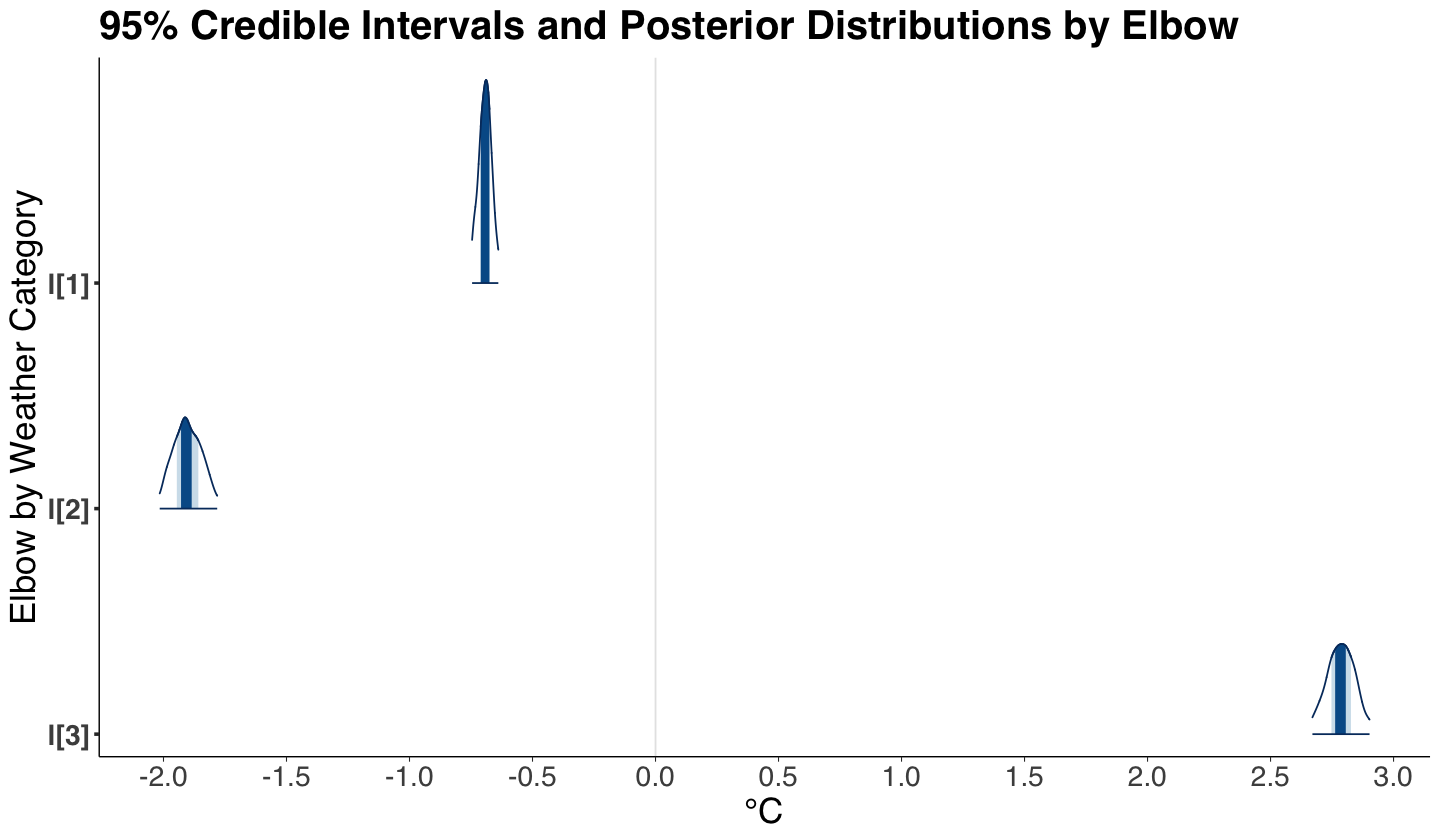

In [19]:
elbow_CIs <- mcmc_areas(posterior_bikeshare, pars = c("l[1]", "l[2]", "l[3]"), prob_outer = 0.95) +
  theme(
    plot.title = element_text(size = 24, face = "bold", family = "sans"),
    axis.text.x = element_text(size = 17, angle = 0, family = "sans"),
    axis.text.y = element_text(size = 17, angle = 0, family = "sans"),
    axis.title = element_text(size = 21, family = "sans")
  ) +
  ggtitle("95% Credible Intervals and Posterior Distributions by Elbow") +
  scale_x_continuous(breaks = seq(-2.5, 3, 0.5)) +
  labs(x = "°C", y = "Elbow by Weather Category")

elbow_CIs

We can obtain the **posterior histograms** by parameter via `mcmc_hist()` from `bayesplot`. The posterior distributions look fairly symmetric! **Note that parameters $a_w$ have positive ranges since we constrain them prior as nonnegative.**

Since we have 450 sampled sets of six parameters each, we can plot 450 times our mean count equation 

$$\lambda_w(t) =  \log\{1+\exp[a_w (t - l_{w})]\}  \quad \text{for} \quad w\in\{1,2,3\}.$$

by weather category. 

```{attention}
Note the low variability across our 450 samples; the lines practically overlap.
```

In [20]:
posterior_samples <- as.data.frame(posterior_bikeshare)

plot_450_samples <- ggplot() +
  xlim(-20, 40) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 21),
    legend.text = element_text(size = 17, margin = margin(r = 2, unit = "cm")),
    legend.title = element_blank(),
    legend.key.size = unit(2, 'cm')
  ) +
  labs(y = "Mean Bike Ride Count", x = "Temperature (C)") +
  ggtitle("Plots of 450 Samples by Weather Category")

# Plotting 450 lambda functions for w_1
for (i in 1:nrow(posterior_samples))
{
  plot_450_samples <- plot_450_samples +
    geom_function(
      fun = function(x) {
        log(1 + exp(posterior_samples$`a[1]`[i] *
          (x - posterior_samples$`l[1]`[i])))
      },
      aes(colour = "Weather 1"), alpha = 0.4
    )
}

# Plotting 450 lambda functions for w_2
for (i in 1:nrow(posterior_samples))
{
  plot_450_samples <- plot_450_samples +
    geom_function(
      fun = function(x) {
        log(1 + exp(posterior_samples$`a[2]`[i] *
          (x - posterior_samples$`l[2]`[i])))
      },
      aes(colour = "Weather 2"), alpha = 0.4
    )
}

# Plotting 450 lambda functions for w_3
for (i in 1:nrow(posterior_samples))
{
  plot_450_samples <- plot_450_samples +
    geom_function(
      fun = function(x) {
        log(1 + exp(posterior_samples$`a[3]`[i] *
          (x - posterior_samples$`l[3]`[i])))
      },
      aes(colour = "Weather 3"), alpha = 0.4
    )
}

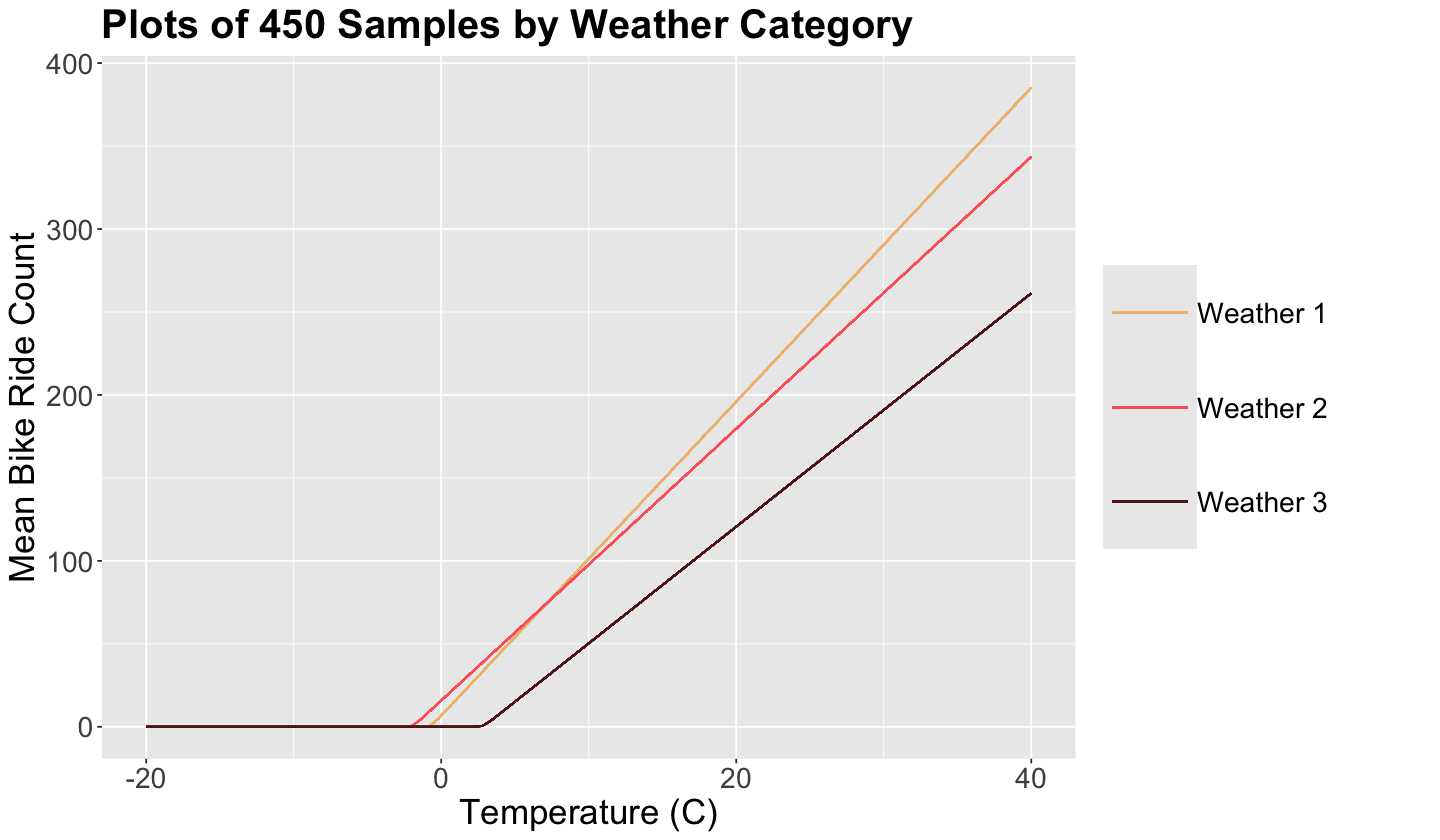

In [21]:
plot_450_samples + scale_color_manual(values = wes_palette(n = 3, name = "GrandBudapest1"))

The harshest weather `3` has the smallest slope and largest elbow. On the other hand, the nicest weather `1` has the largest slope but not the smallest elbow!

```{exercise}
:label: lecture4-q4

Once we have estimated our Bayesian model, what do you think is the major drawback? Thus, how can we improve this model?
```

## 6. Wrapping Up

- We have built a Bayesian generative model totally from scratch by setting up key mathematical relations between our variables of interest.
- Knowing the suitable class of distributions to use is of particular importance.
- There is more than one possible modelling approach, and all models can be improved! 